# ROI detection (segmentation) defacer ver 1.0 
## -ears label update 
## Asan Medical Center

  
#### &nbsp;

In [1]:
'''
# Dependencies:
# Using tensorflow backend

!pip install keras
!pip install nibabel
!pip install SimpleITK
!pip install sklearn
'''



'\n# Dependencies:\n# Using tensorflow backend\n\n!pip install keras\n!pip install nibabel\n!pip install SimpleITK\n!pip install sklearn\n'

In [1]:
import os
import glob
import math
import time
import datetime as dt
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import random
from scipy import ndimage
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
from matplotlib import colors

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD


from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from skimage.filters import threshold_triangle
from skimage.morphology import remove_small_holes
from skimage.measure import marching_cubes_lewiner

from tensorflow.keras import layers, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Convolution3D, MaxPooling3D, UpSampling3D, ZeroPadding3D,  BatchNormalization, concatenate, Conv3D
from tensorflow.keras.layers import Lambda, ReLU, Multiply, Reshape, ThresholdedReLU
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D, Cropping3D, Conv3DTranspose, GlobalAveragePooling3D
from tensorflow.keras.layers import BatchNormalization, GaussianNoise
from tensorflow.keras.layers import concatenate, add, multiply
from tensorflow.keras.layers import Activation


# Load Data

In [2]:
config = dict() #configuration info

In [3]:
 
config["path_image"] = 'D:/brainData/defaceTrain/new_image'
config["path_label"] = 'D:/brainData/defaceTrain/new_label'




#Load .nii.gz files
list_train_image = glob.glob(os.path.join(config["path_image"],'*.nii.gz'))
list_train_label = glob.glob(os.path.join(config["path_label"],'*.nii.gz'))

In [4]:
# x_train =list_train_image[0:-40]
# y_train =list_train_label[0:-40]
# x_valid =list_train_image[-40:-20]
# y_valid =list_train_label[-40:-20]
# x_test =list_train_image[-20:]
# y_test =list_train_label[-20:]

from sklearn.model_selection import train_test_split
x_train, x_valid_test, y_train, y_valid_test = train_test_split(
    list_train_image, 
    list_train_label,
    shuffle = True,
    test_size=96,
    random_state=1)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid_test, 
    y_valid_test,
    shuffle = True,
    test_size=48,
    random_state=1)


In [5]:
# 제대로 들어갔는지 확인 
print ( 
    'Training set : ', len(x_train),
    '\n\nValidation set : ', len(x_valid), 
    '\n\nTest set : ', len(x_test)
    
)

Training set :  144 

Validation set :  48 

Test set :  48


# Data Augmentation

In [6]:
import keras_image_preprocessing
datagen = keras_image_preprocessing.ImageDataGenerator(
                                        rotation_range=[15.,15.,15.],
                                        zoom_range=[0.90, 1.10],
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        depth_shift_range=0.10,
                                        shear_range=0.20,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        depthly_flip=True,
                                        axis_transpose=True,
                                        fill_mode='constant',cval=0.)

Using TensorFlow backend.


In [7]:
def data_aug(img, label, color_reversal=True):
    
    seed = np.random.randint(100000)
    for img in datagen.flow(img, batch_size=1, seed = seed ):
#         if color_reversal:
#         	if np.random.random() < 0.3:
#         		img = np.max(img)-img
        break
        
    for label in datagen.flow(label, batch_size=1, seed = seed):
        break
    return img, label

In [8]:
config['aug_index']= 3 # generate augmentation images per single training data.

# 3D Unet Model 

In [9]:
#configure parameter & hyper parameter

config["img_channel"] = 1
config["num_multilabel"] = 4 # the number of label (channel last)
config["noise"] = 0.1
config["batch_size"] = 1 # 3D segmentation learning needs too large GPU memory to increase batch size. # this script is optimized for single batch size 
config["resizing"] = True #True -> resize input image for learning. if you don't have enough GPU memory.
config["input_shape"] = [128, 128, 128, 1] # smaller GPU memory smaller image size

    
config["epochs"] = 100 

In [10]:
# loss function

def dice_score(y_true, y_pred):
    smooth = 1.
    label_length = y_pred.get_shape().as_list()[-1] #the number of label (channel last)
    
    loss = 0    
    for num_labels in range(label_length):
        y_true_f = K.flatten(y_true[..., num_labels])
        y_pred_f = K.flatten(y_pred[..., num_labels])
        intersection = K.sum(y_true_f * y_pred_f)
        loss += (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
   
    return loss/label_length 

def dice_loss(y_true, y_pred):
    return 1-dice_score(y_true, y_pred) + 0.1*K.categorical_crossentropy(y_true, y_pred)
'''
Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
'''


def tversky_loss(beta): # beta : [0,1] the bigger beta, the more penaly on False Positive
    def t_loss(y_true, y_pred):
        loss = 0
        label_length = y_pred.get_shape().as_list()[-1] # the number of label (channel last)
        smooth = 1
        
        for num_labels in range(label_length):
            y_true_f = K.flatten(y_true[..., num_labels])
            y_pred_f = K.flatten(y_pred[..., num_labels])
            numerator = K.sum(y_true_f * y_pred_f)
            denominator = y_true_f * y_pred_f + beta * (1 - y_true_f) * y_pred_f + (1 - beta) * y_true_f * (1 - y_pred_f)
            loss += (numerator+ smooth) / (K.sum(denominator) + smooth)
        return 1-(loss / label_length) + 0.1*K.categorical_crossentropy(y_true, y_pred)
        
    return t_loss


def focal_tversky(y_true,y_pred):
    pt_1 = tversky_loss(0.7)(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


def resize(data, img_dep=config["input_shape"][0], img_cols=config["input_shape"][1], img_rows=config["input_shape"][2]):
    resize_factor = (img_dep/data.shape[0], img_cols/data.shape[1], img_rows/data.shape[2])
    data = ndimage.zoom(data, resize_factor, order=0, mode='constant', cval=0.0)
    return data
'''
ndimage.zoom(어레이 데이터 인풋,축별로zoom factor. 숫자하나면 각축에 적용.,
The order of the spline interpolation. 0-5까지 옵션있음 ,

'''

    
# keras_contrib.layers.InstanceNormalization
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [11]:
#InstanceNormalization
def unet_model(input_shape, num_labels, axis=-1, base_filter=16, se_res_block=True, se_ratio=16, noise=0.1, atten_gate=False):
    def conv3d(layer_input, filters, axis=-1, se_res_block=True, se_ratio=-1, down_sizing=True):
        if down_sizing == True:
            layer_input = MaxPooling3D(pool_size=(2, 2, 2))(layer_input)

        d1 = Conv3D(filters, (3, 3, 3), use_bias=False, padding='same')(layer_input)
        d1 = InstanceNormalization(axis=axis)(d1)
        d1 = ReLU()(d1)
        
        d = Conv3D(filters, (3, 3, 3), use_bias=False, padding='same')(d1)
        d = InstanceNormalization(axis=axis)(d)
        if se_res_block == True:
            se = GlobalAveragePooling3D()(d)
            se = Dense(filters // se_ratio, activation='relu')(se)
            se = Dense(filters, activation='sigmoid')(se)
            se = Reshape([1, 1, 1, filters])(se)
            d = Multiply()([d, se])
            shortcut = InstanceNormalization(axis=axis)(d1)
            d = add([d, shortcut])
        d = ReLU()(d)
        return d

    def deconv3d(layer_input, skip_input, filters, axis=-1, se_res_block=True, se_ratio=8, atten_gate=False):
        if atten_gate == True:
            gating = Conv3D(filters, (1, 1, 1), use_bias=True,  padding='valid')(layer_input)
            gating = InstanceNormalization(axis=axis)(gating)
            attention = Conv3D(filters, (2, 2, 2), strides=(2, 2, 2), use_bias=False,  padding='valid')(skip_input)
            attention = InstanceNormalization(axis=axis)(attention)
            attention = add([gating, attention])
            attention = ReLU()(attention)
            attention = Conv3D(1, (1, 1, 1), use_bias=False, 
                               padding='same', activation='sigmoid')(attention)
           
            
            attention = UpSampling3D((2, 2, 2))(attention)
            attention = Lambda(lambda x: K.tile(
                x, [1, 1, 1, 1, filters]))(attention)
            skip_input = Multiply()([attention, skip_input])
            
        #one deconv 
        u1 = Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), use_bias=False,  padding='same')(layer_input)
        u1 = InstanceNormalization(axis=axis)(u1)
        u1 = ReLU()(u1)
        u1 = concatenate([u1, skip_input],axis=axis)
        
        #two conv 
        u2 = Conv3D(filters, (3, 3, 3), use_bias=False,  padding='same')(u1)     
        u2 = InstanceNormalization(axis=axis)(u2)
        u2 = ReLU()(u2)
        u2 = Conv3D(filters, (3, 3, 3), use_bias=False,  padding='same')(u2)
        u2 = InstanceNormalization(axis=axis)(u2)
       
        if se_res_block == True:
            se = GlobalAveragePooling3D()(u2)
            se = Reshape((1, 1, 1, filters))(se)
            se = Dense(filters // se_ratio, activation='relu', use_bias=False)(se)
            se = Dense(filters, activation='sigmoid', use_bias=False)(se)
            se = Reshape([1, 1, 1, filters])(se)
            se = Multiply()([u2, se])
            u2 = add([u2, se])
        u2 = ReLU()(u2)
        
       
        return u2


    
    input_img = Input(shape=input_shape)
    d0 = GaussianNoise(noise)(input_img)

    d0 = conv3d(d0, base_filter, se_res_block=se_res_block, se_ratio=se_ratio, down_sizing=False) #original size
    d1 = conv3d(d0, base_filter*2, se_res_block=se_res_block, se_ratio=se_ratio) # /2 
    d2 = conv3d(d1, base_filter*4, se_res_block=se_res_block, se_ratio=se_ratio) # /4
    d3 = conv3d(d2, base_filter*8, se_res_block=se_res_block, se_ratio=se_ratio) # /8 

    u2 = deconv3d(d3, d2, base_filter*4, se_res_block=se_res_block, se_ratio=se_ratio)
    u1 = deconv3d(u2, d1, base_filter*2, se_res_block=se_res_block, se_ratio=se_ratio)
    u0 = deconv3d(u1, d0, base_filter, se_res_block=se_res_block, se_ratio=se_ratio)
    
    
    output_img = Conv3D(num_labels, kernel_size=1, strides=1, 
                        padding='same', activation='softmax')(u0)
    
    

    model = Model(inputs=input_img, outputs=output_img)   

    return model

In [12]:
model = unet_model(input_shape=config["input_shape"],
                   num_labels=config["num_multilabel"],
                   base_filter=16,
                   se_res_block=True,
                   se_ratio=16,  
                   atten_gate=True
                   )


model.compile(optimizer=Adam(lr=0.0002),loss=dice_loss, metrics=[dice_score])


###  training function

In [13]:
# 5D tensor (batch,img_dep,img_cols,img_rows,img_channel)
def load_batch(x_list,y_list=0, batch_size=1):
    
    image = sitk.GetArrayFromImage(sitk.ReadImage(x_list)).astype('float32')
    if config["resizing"] == True : 
        image = resize(image)
        img_shape = image.shape
    else:
        img_shape = image.shape

    image = np.reshape(image,(config["batch_size"] ,img_shape[0], img_shape[1], img_shape[2] , config["img_channel"])) # batch, z ,y, x , ch
    n_image = (image-np.min(image))/(np.max(image)-np.min(image))
  
    label=0
    if y_list!=0:
        labels = sitk.GetArrayFromImage(sitk.ReadImage(y_list)).astype('float32')
        if config["resizing"] == True : 
            labels = resize(labels)
            lb_shape = labels.shape
        else:
            lb_shape = labels.shape
            

        onehot = to_categorical(labels)     
        label = np.reshape(onehot,(config["batch_size"] ,lb_shape[0], lb_shape[1], lb_shape[2], config["num_multilabel"] ))

    
     
    return n_image,label
       


In [14]:
def train(x_train,y_train):
    
    train_dice = []
    count=0
    for i in range(len(x_train)):
        image0, label0 = load_batch(x_train[i],y_train[i],config["batch_size"])
        train_loss_tmp = model.train_on_batch(image0, label0) #original image training
        train_dice.append(train_loss_tmp[1])
        count+=1
        
        print( '\r'+'\033[91m'+ "complete {} / {} average Metrics : {} , Metrics : {}" 
                  .format(count, len(x_train)+len(x_train)*config['aug_index'], np.mean(np.array(train_dice)) ,train_loss_tmp[1] ) , end="")
        
       
        for index in range(config['aug_index']):     #train augmentation images as the number of config['aug_index']
            image, label = data_aug(image0, label0)
            train_loss_tmp = model.train_on_batch(image, label) 
            
            train_dice.append(train_loss_tmp[1])
            count+=1
            
            print("\rcomplete {} / {} average Metrics : {} , Metrics : {}" 
                  .format(count, len(x_train)+len(x_train)*config['aug_index'], np.mean(np.array(train_dice)) ,train_loss_tmp[1] ) , end="")
        
    train_dice = np.mean(np.array(train_dice))
    return train_dice

def valid(x_valid,y_valid):
    
    valid_dice = []
    for i in range(len(x_valid)):
        image, label = load_batch(x_valid[i],y_valid[i],config["batch_size"]) 
        valid_loss_tmp = model.evaluate(image,label,verbose=0)
        valid_dice.append(valid_loss_tmp[1])
        for i in range(1):
            image, label = data_aug(image, label)
            valid_loss_tmp = model.evaluate(image,label,verbose=0)
            valid_dice.append(valid_loss_tmp[1])
            
    valid_dice = np.mean(np.array(valid_dice))
    return valid_dice   

def test(x_valid,y_valid):
    
    valid_dice = []
    for i in range(len(x_valid)):
        image, label = load_batch(x_valid[i],y_valid[i],config["batch_size"]) 
        valid_loss_tmp = model.evaluate(image,label,verbose=0)
        valid_dice.append(valid_loss_tmp[1])
            
    #valid_dice = np.mean(np.array(valid_dice))
    return valid_dice   

### check configuration

In [15]:
config

{'path_image': 'D:/brainData/defaceTrain/new_image',
 'path_label': 'D:/brainData/defaceTrain/new_label',
 'aug_index': 3,
 'img_channel': 1,
 'num_multilabel': 4,
 'noise': 0.1,
 'batch_size': 1,
 'resizing': True,
 'input_shape': [128, 128, 128, 1],
 'epochs': 100}

# Train - model save

In [16]:
score_check = [0.]
for num_epoch in range(config["epochs"]):
        
    # shuffling training set 
    combined = list(zip(x_train, y_train))
    random.shuffle(combined)
    x_train[:], y_train[:] = zip(*combined)

    
    # training
    train_dice = train(x_train,y_train)

    # validation
    valid_dice = valid(x_valid,y_valid)
    
    
    # model save when validation dice coef. improved
    if np.max(score_check) < valid_dice: 
        model.save('model_keras224.h5')
        print('\nEpochs',num_epoch,'train:',f'{train_dice:.3f}','valid:',f'{valid_dice:.3f}','[saved]', "\t", dt.datetime.now())
    else:
        print('\nEpochs',num_epoch,'train:',f'{train_dice:.3f}','valid:',f'{valid_dice:.3f}', "\t", dt.datetime.now())
    
    score_check.append(valid_dice)
    print('\n')
    
    #early stop option: if there is no improvement during the last 5 epochs, the learning stops.
    if np.max(score_check[-5:]) < np.max(score_check): 
        
        break
        

model.save('model_2_last.h5') # save model at last epoch

complete 576 / 576 average Metrics : 0.22796536565551329 , Metrics : 0.3606330156326294403773
Epochs 0 train: 0.228 valid: 0.342 [saved] 	 2020-08-31 11:58:45.861423


complete 576 / 576 average Metrics : 0.43165834149759674 , Metrics : 0.6057018637657166885564
Epochs 1 train: 0.432 valid: 0.572 [saved] 	 2020-08-31 12:09:44.337879


complete 576 / 576 average Metrics : 0.67037882293678 , Metrics : 0.70289158821105960136912
Epochs 2 train: 0.670 valid: 0.742 [saved] 	 2020-08-31 12:20:48.249123


complete 576 / 576 average Metrics : 0.7420805585053232 , Metrics : 0.622121214866638205273
Epochs 3 train: 0.742 valid: 0.748 [saved] 	 2020-08-31 12:31:49.262386


complete 576 / 576 average Metrics : 0.7626407318231132 , Metrics : 0.762636184692382800153
Epochs 4 train: 0.763 valid: 0.773 [saved] 	 2020-08-31 12:42:43.382223


complete 576 / 576 average Metrics : 0.767871649728881 , Metrics : 0.7520558834075928288757
Epochs 5 train: 0.768 valid: 0.792 [saved] 	 2020-08-31 12:53:43.330950




# Model test -test set(labeled data) evaluation



In [17]:
model.load_weights('model_keras224.h5') # load only weight

In [12]:
# import model structure and weight
#from tensorflow.keras.models import load_model
#model = load_model('model_2_tv.h5',custom_objects={'InstanceNormalization':InstanceNormalization,'t_loss':tversky_loss(0.8),'dice_score':dice_score})

In [18]:
# onehot results -> argmax
def onehot2label (onehot_array) :
    onehot_array = np.argmax(onehot_array,axis=-1)
    label=onehot_array[...,np.newaxis]

    return label

In [20]:
# image, label = load_batch(list_test_image[0],list_test_label[0],batch_size = 1)
# image, label = data_aug(image, label)
# pred = onehot2label(label)



# cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
# bounds=[0,1,2,3,4,5,6]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# num_slice = 60
# plt.figure(figsize=(15,10))
# plt.subplot(2,2,1)
# plt.title('GroundTruth axial = {}'.format(num_slice))

# plt.imshow(image[0,:,num_slice,:,0],cmap='gray')


# plt.subplot(2,2,2)
# plt.title('Prediction {}'.format(num_slice))

# plt.imshow(image[0,:,num_slice,:,0],cmap='gray')
# plt.imshow(pred[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)

In [36]:
def view_result (test_num, first_axial_slice=45 , second_axial_slice =60):
    i = test_num
    
    image, label = load_batch(list_test_image[i],list_test_label[i],batch_size = 1)
    '''
    # y axis flip test
    image = image[:,:,::-1,:,:]
    label = label[:,:,::-1,:,:]
    
    image = np.transpose(image,(0,3,2,1,4)) 
    label = np.transpose(label,(0,3,2,1,4))
    '''
    results = model.predict(image)
    
    
    groundtruth = onehot2label(label)
    pred = onehot2label(results)

    
    cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
    bounds=[0,1,2,3,4,5,6]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    num_slice = first_axial_slice
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('GroundTruth axial = {}'.format(num_slice))
    
    plt.imshow(image[0,:,num_slice,:,0],cmap='gray')
    
    plt.imshow(groundtruth[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)
    plt.subplot(2,2,2)
    plt.title('Prediction {}'.format(num_slice))
   
    plt.imshow(image[0,:,num_slice,:,0],cmap='gray')
    plt.imshow(pred[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)
    
    print("axial = {}".format(num_slice),"\nprediction = ",set(list(pred[0,:,num_slice,:,0].flatten())))
    print("ground truth = ", set(list(groundtruth[0,:,num_slice,:,0].flatten())))
    print("\n")

    num_slice = second_axial_slice
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('GroundTruth {}' .format(num_slice))
   
    plt.imshow(image[0,:,num_slice,:,0],cmap='gray')
    
    plt.imshow(groundtruth[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)
    plt.subplot(2,2,2)
    plt.title('Prediction {}'.format(num_slice))
    
    plt.imshow(image[0,:,num_slice,:,0],cmap='gray')

    
    plt.imshow(pred[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm) # alpha : opacity
    print("axial = {}".format(num_slice),"\nprediction = ",set(list(pred[0,:,num_slice,:,0].flatten())))
    print("ground truth = ", set(list(groundtruth[0,:,num_slice,:,0].flatten())))
    print("\n")


axial = 45 
prediction =  {0, 2, 3}
ground truth =  {0, 2, 3}


axial = 60 
prediction =  {0, 1}
ground truth =  {0, 1}




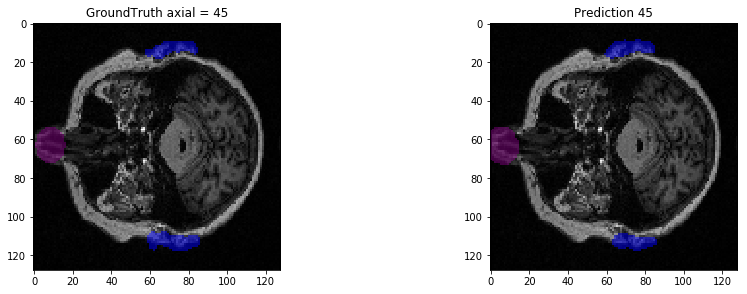

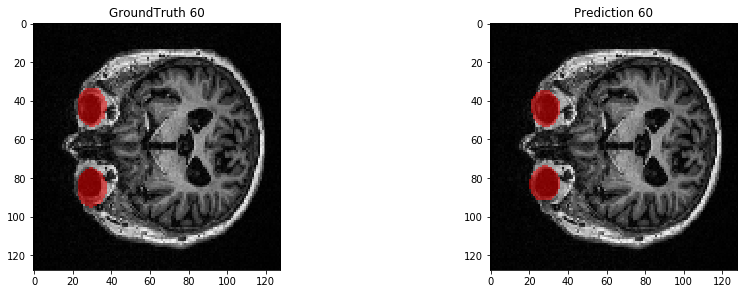

In [23]:
view_result(1,45,60) # second test file view

# save image file

In [19]:
config["test_label_save_path"] = 'D:/brainData/testblur/option test'

In [20]:
#creating bound box of segmentation result. Ignoring execpt facial features(eyes, nose and ears) by using labeling, region prop 
#input: predicted label by model. ndarray(z,y,x,ch),
#output : bounding box coordinates list([z,y,x,Z, Y, X],[z,y,x,Z, Y, X],... as number of label clusters)
def bounding_box(results):

    boxes = list()
    for ch in range(results.shape[-1]):  # except 0 label (blanck)
        if ch == 0 or ch == 2: # eyes, ears
            
            result = np.round(results[...,ch])
            lb=label(result,connectivity=1)
            
            if np.max(lb) > 2:
                region_list = [region.area for region in regionprops(lb)]       
                lb=remove_small_objects(lb, min_size=np.max(region_list)*0.3)
            
            if len(regionprops(lb))!=2 :
                raise print('\nROI detection failed', ch, len(regionprops(lb)))

            for region in regionprops(lb):
                 boxes.append(list(region.bbox))
        
        
        if ch==1 : # nose
           
            result = np.round(results[...,ch])
            lb=label(result,connectivity=1)

            if np.max(lb) > 1:
                region_list = [region.area for region in regionprops(lb)]       
                lb=remove_small_objects(lb, min_size=np.max(region_list)*0.3)
            
            if len(regionprops(lb))!=1 :
                raise print('\nROI detection failed', ch)

            for region in regionprops(lb):
                 boxes.append(list(region.bbox))
    
    return boxes

In [21]:
#input: 'xyz order' 3D array by nib.load, bound box coordinates, coordimnates of bounding box, processing type = blur or wipe(remove voxel)
#output: processed image array.
def box_blur(im_array,  box, Type, wth=1):
    
    # increase or decrease the size of the box by 'wth' times
    if wth != 1 :
        for c in range(3):
            mean_= (box[c]+box[c+3])/2
            box[c]=int(np.round(mean_-wth*(mean_-box[c])))
            box[c+3]=int(np.round(wth*(box[c+3]-mean_)+mean_))
            if box[c] < 0: box[c]=0
            if box[c+3] > im_array.shape[2-c]: box[c+3] = im_array.shape[2-c]   #order : im_array-> x,y,z / box-> z,y,x

 
    
    #voxel coordinates must be 'int'
    box_z1 = box[0]
    box_y1 = box[1]
    box_x1 = box[2]
    box_z2 = box[3]
    box_y2 = box[4]
    box_x2 = box[5]
    
    
    if Type.lower() =='blur':
        blurr_array = ndimage.median_filter(im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2],size=5) #size = filter size
        im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = blurr_array
    elif Type.lower() =='wipe':
        
        im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = 0
    else:
        raise print("type option error : select 'Blur' or 'Wipe'")
    
    return im_array


In [22]:
#input: 'xyz order' 3D array by nib.load, bound box coordinates, coordimnates of bounding box, processing type = blur or wipe(remove voxel)
# wth : You can increase or decrease the size of the box by 'wth' times.
# dep : Thickness to blur along surface.
#output: processed image array.
def surface_blur(im_array, edge_img, box, Type, wth ,dep):
    
    
    # increase or decrease the size of the box by 'wth' times
    if wth != 1 :
        for c in range(3):
            mean_= (box[c]+box[c+3])/2
            box[c]=int(np.round(mean_-wth*(mean_-box[c])))
            box[c+3]=int(np.round(wth*(box[c+3]-mean_)+mean_))
            if box[c] < 0: box[c]=0
            if box[c+3] > im_array.shape[2-c]: box[c+3] = im_array.shape[2-c]   #order : im_array-> x,y,z / box-> z,y,x

    
    
    #voxel coordinates must be 'int'
    box_z1 = box[0]
    box_y1 = box[1]
    box_x1 = box[2]
    box_z2 = box[3]
    box_y2 = box[4]
    box_x2 = box[5]
    
    mini_array = im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2]            
    mini_edge = edge_img[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2]
    processing_area = np.zeros_like(mini_array)

    
    # dep  =eyes=2~3 ears 1~2
    if Type.lower() =='blur':
        where_true=np.where(mini_edge==True)
        
        for i in range(len(where_true[0])):
            x=where_true[0][i]
            y=where_true[1][i]
            z=where_true[2][i]
            processing_area[x-dep:x+dep,y-dep:y+dep,z-dep:z+dep] = 1
            
        
        
        threshold = np.max(ndimage.gaussian_filter(mini_array[processing_area==1],sigma=3))
        mini_array[processing_area==1] = threshold
 
        
    
    elif Type.lower() =='wipe':
        where_true=np.where(mini_edge==True)

        for i in range(len(where_true[0])):
            x=where_true[0][i]
            y=where_true[1][i]
            z=where_true[2][i]
            mini_array[x-dep:x+dep,y-dep:y+dep,z-dep:z+dep]=0

    
    else:
        raise print("type option error : select 'Blur' or 'Wipe'")
    
    
    im_array[box_x1:box_x2,box_y1:box_y2,box_z1:box_z2] = mini_array 
    
    return im_array

In [23]:
def outer_contour_3D(image,zoom=1):
    #sort in standard size
    resize_factor = (128/image.shape[0], 128/image.shape[1], 128/image.shape[2])
    ima = ndimage.zoom(image,resize_factor,order=0, mode='constant', cval=0.0)
    
    # make binary cast
    thresh = threshold_triangle(ima)
    imageg=ndimage.median_filter(ima,size=3)
    binary_image = imageg > thresh
    for s in range(ima.shape[0]) :
        binary_image[s,:,:]=ndimage.morphology.binary_fill_holes(binary_image[s,:,:])
    for s in range(ima.shape[1]) :
        binary_image[:,s,:]=ndimage.morphology.binary_fill_holes(binary_image[:,s,:])
    for s in range(ima.shape[2]) :
        binary_image[:,:,s]=ndimage.morphology.binary_fill_holes(binary_image[:,:,s])
    
    # draw outer contour
    verts, faces, norm, val = marching_cubes_lewiner(binary_image,0)
    vint = np.round(verts).astype('int')
    contour = np.zeros_like(binary_image)
    for s in vint:
        contour[s[0],s[1],s[2]]=1
    
    # shrink contour image cuz of the gaussian_filter we used earlier.
    if zoom !=1 :
        c_shape = contour.shape
        zoom_ = ndimage.zoom(contour,zoom,order=0, mode='constant', cval=0.0)
        zoom_shape = zoom_.shape
        npad = ( (int(np.ceil((c_shape[0]-zoom_shape[0])/2)),int((c_shape[0]-zoom_shape[0])/2)), 
                (int(np.ceil((c_shape[1]-zoom_shape[1])/2)),int((c_shape[1]-zoom_shape[1])/2)),
                (int(np.ceil((c_shape[2]-zoom_shape[2])/2)),int((c_shape[2]-zoom_shape[2])/2)) )

        contour_3D = np.pad(zoom_,npad,'constant',constant_values = (0))
    elif zoom==1 : 
        contour_3D = contour
    
    #Revert to original size
    get_back = (image.shape[0]/128, image.shape[1]/128, image.shape[2]/128)
    contour_3D = ndimage.zoom(contour_3D,get_back,order=0, mode='constant', cval=0.0)
    
    return contour_3D

In [24]:
def nifti_view_label (image,labels,boxes,path,file_name):
   
    pred = np.argmax(labels,axis=-1)
    
    boxes =np.array(boxes)
    centers = (boxes[:,0:3]+boxes[:,3:6])/2 #centers of nose, right ear, left ear
    axial_plane = np.argmin(np.var(centers[2:5],axis=0)) # 코와 귀 2개 좌표만 뽑아서 가장 분산이 작은 축을 구함 = axial 축일것이라 예상됨.
    
    ones = np.ones(image.shape)
    for i in range(len(boxes)):
        ones = box_blur(ones,boxes[i],Type='wipe')
    
    ones = 1-ones
    pred = pred*ones.T
    
    
    image =image.T
    
    cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
    bounds=[0,1,2,3,4,5,6]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    if axial_plane == 0:

        plt.figure(figsize=(15,10))
        
        plt.subplot(1,3,1)
        slice_num = int((centers[0][axial_plane]+centers[1][axial_plane])/2)
        plt.title('predicted eyes: axial = {}'.format(slice_num))
        plt.imshow(image[slice_num,:,:],cmap='gray')
        plt.imshow(pred[slice_num,:,:],alpha=0.5,cmap=cmap, norm=norm)
        
        plt.subplot(1,3,2)
        slice_num = int(centers[2][axial_plane])
        plt.title('predicted nose: axial = {}'.format(slice_num))
        plt.imshow(image[slice_num,:,:],cmap='gray')
        plt.imshow(pred[slice_num,:,:],alpha=0.5,cmap=cmap, norm=norm)

        plt.subplot(1,3,3)
        slice_num = int((centers[3][axial_plane]+centers[4][axial_plane])/2)
        plt.title('predicted ears: axial = {}' .format(slice_num))
        plt.imshow(image[slice_num,:,:],cmap='gray')
        plt.imshow(pred[slice_num,:,:],alpha=0.5,cmap=cmap, norm=norm)
        
    
    elif axial_plane == 1:

        plt.figure(figsize=(15,10))
        
        plt.subplot(1,3,1)
        slice_num = int((centers[0][axial_plane]+centers[1][axial_plane])/2)
        plt.title('predicted eyes: axial = {}'.format(slice_num))
        plt.imshow(image[:,slice_num,:],cmap='gray')
        plt.imshow(pred[:,slice_num,:],alpha=0.5,cmap=cmap, norm=norm)
        
        plt.subplot(1,3,2)
        slice_num = int(centers[2][axial_plane])
        plt.title('predicted nose: axial = {}'.format(slice_num))
        plt.imshow(image[:,slice_num,:],cmap='gray')
        plt.imshow(pred[:,slice_num,:],alpha=0.5,cmap=cmap, norm=norm)

        plt.subplot(1,3,3)
        slice_num = int((centers[3][axial_plane]+centers[4][axial_plane])/2)
        plt.title('predicted ears: axial = {}' .format(slice_num))
        plt.imshow(image[:,slice_num,:],cmap='gray')
        plt.imshow(pred[:,slice_num,:],alpha=0.5,cmap=cmap, norm=norm)
        
        
    elif axial_plane == 2:

        plt.figure(figsize=(15,10))
        
        plt.subplot(1,3,1)
        slice_num = int((centers[0][axial_plane]+centers[1][axial_plane])/2)
        plt.title('predicted eyes: axial = {}'.format(slice_num))
        plt.imshow(image[:,:,slice_num],cmap='gray')
        plt.imshow(pred[:,:,slice_num],alpha=0.5,cmap=cmap, norm=norm)
        
        plt.subplot(1,3,2)
        slice_num = int(centers[2][axial_plane])
        plt.title('predicted nose: axial = {}'.format(slice_num))
        plt.imshow(image[:,:,slice_num],cmap='gray')
        plt.imshow(pred[:,:,slice_num],alpha=0.5,cmap=cmap, norm=norm)
        plt.subplot(1,3,3)
        slice_num = int((centers[3][axial_plane]+centers[4][axial_plane])/2)
        plt.title('predicted ears: axial = {}' .format(slice_num))
        plt.imshow(image[:,:,slice_num],cmap='gray')
        plt.imshow(pred[:,:,slice_num],alpha=0.5,cmap=cmap, norm=norm)
    
 
    pic_name = os.path.join(path,'label_{}.png'.format(os.path.basename(file_name)))
    plt.savefig(pic_name, bbox_inches='tight')
    plt.close('all')


In [25]:
#where_do_you_want_to_blur? ex) where = (1,1,1) -> blur(eyes, nose, ears)
def Deidentification_image(where, Type, list_test_image, model=model):
    '''
    where : list or tuple. Each position stands for eyes nose ears (eyes, nose, ears) 
            If the corresponding position is 1, de-identification process.
    
    Type : Image processing options. 'Wipe' , 'Blurr'
    
    list_of_image : Test set(labled or unlabled) data path. 
    model : Predictive model to be applied.

    '''
    # if typing another word, error raise. 
    options=['blur','wipe']
    if Type.lower() not in options: 
        raise print("type option error : select 'Blur' or 'Wipe'") 
    
    
    
    for i in range(len(list_test_image)): # load image of i th : 0 ~
        
        raw_img = nib.load(list_test_image[i]) # get affine and header of original image file.
        array_img = raw_img.get_fdata() # image array
        original_shape = array_img.shape #  (x,y,z)
        thresh = threshold_triangle(array_img)
        
        #load prediction label 
        image, l_ = load_batch(list_test_image[i]) #z, y, x 
        results = model.predict(image)
        results = np.round(results)
        
        
        #preprocessing: Size recovery and transform onehot to labels number 
        if config["resizing"]==True :
            results = onehot2label(results)
            results = np.reshape(results,config["input_shape"][0:3]) # prediction results (batch size, dep, col ,row, ch) -> (dep, col ,row)
            results = resize(results,
                                 img_dep=original_shape[2],
                                 img_cols=original_shape[1],
                                 img_rows=original_shape[0]) 
            results = to_categorical(results)

        else:
            results=results[0,...] # Only if batch size==1
        
        #search center by clustering
        boxes = bounding_box(results[...,1:])    
           
    
            
        #view label with .png
        path = config["test_label_save_path"] # label이 보이는 사진을 저장할 경로
        nifti_view_label(array_img,results,boxes, path=path, file_name=list_test_image[i])
        
        
        # 
        if where[1] == 1: # nose
            box = boxes[2]
            array_img = box_blur(array_img, box, Type='wipe', wth=1.33)
        
        ## make outer contour for mini array.
        edge_img = outer_contour_3D(array_img,zoom=1)
        
        
        if where[0] == 1: # eyes
                                   
            box = boxes[0] # eye
            array_img = surface_blur(array_img, edge_img, box, Type='blur', wth=1.5, dep=3)
            
            box = boxes[1] # eye
            array_img = surface_blur(array_img, edge_img, box, Type='blur', wth=1.5, dep=3)               
        
        
            
        if where[2] == 1: # ears
            '''
            In order not to see the outline of the ear due to external noise,
            fill the area of the ear with similar noise
            '''
            ear_results = results[...,3]
            border = box_blur(np.ones(array_img.shape),boxes[3],Type='wipe') #'box_blur' function is based on array_img.shape (nibabel liabrary)
            border = box_blur(border,boxes[4],Type='wipe')
            border = 1-border
            ear_results = border*ear_results.T
            
            noise = np.random.rand(*original_shape)*thresh*0.8 
            array_img[ear_results == 1] = noise[ear_results == 1]

        array_img=np.round(array_img)
        array_img=np.array(array_img,dtype='int32')
        
        
        if Type.lower() =='blur':
            nib.save(nib.Nifti1Image(array_img , raw_img.affine, raw_img.header),
                     os.path.join(config["test_label_save_path"],'Blurred_{}'.format(os.path.basename(list_test_image[i]))))    
        elif Type.lower() =='wipe':
            nib.save(nib.Nifti1Image(array_img , raw_img.affine, raw_img.header),
                     os.path.join(config["test_label_save_path"],'Wipe_{}'.format(os.path.basename(list_test_image[i]))))   
    


In [26]:
# Creat Nifty file(.nii.gz) of just prediction label 

def save_label_pred(list_test_image, model=model, option=False):
    
    for i in range(len(list_test_image)): 
        raw_img = nib.load(list_test_image[i])
        original_shape = raw_img.get_fdata().shape #  (x,y,z)
        
        image, labels = load_batch(list_test_image[i])
        results = model.predict(image)
        
        if option == True : # noise removing process
            for ch in range(1,config["num_multilabel"]): # except 0 label (blanck)
                if ch!=2 : # eyes, ears

                    result = np.round(results[0,...,ch]) # only batch size = 1
                    lb=label(result,connectivity=1)

                    region_list=list()
                    for region in regionprops(lb):
                        region_list.append(region.area)

                    region_list_sort = sorted(region_list)
                    
                    lb=np.array(lb,dtype=bool)
                    lb=remove_small_objects(lb, min_size=region_list_sort[-2])
                    results[0,...,ch]=results[0,...,ch]*lb

                if ch==2 : # nose

                    result = np.round(results[0,...,ch])  # only batch size = 1
                    lb=label(result,connectivity=1)

                    region_list=list()
                    for region in regionprops(lb):
                        region_list.append(region.area)

                    max_size= np.max(region_list)
                    lb=np.array(lb,dtype=bool)
                    lb=remove_small_objects(lb, min_size=max_size)
                    results[0,...,ch]=results[0,...,ch]*lb
            
            

        results = onehot2label(results)
        results = np.reshape(results,config["input_shape"][0:3]) # prediction results (batch size, dep, col ,row, ch) -> (dep, col ,row)
        if config["resizing"]==True :
            results = resize(results,
                             img_dep=original_shape[2],
                             img_cols=original_shape[1],
                             img_rows=original_shape[0]) # recovery to original size
                
        results_reshaped = np.transpose(results,(2,1,0))     #nibabel library : x y z order, simpleITK library : z y x order.
    

        nib.save(nib.Nifti1Image(results_reshaped , raw_img.affine, raw_img.header),
                 os.path.join(config["test_label_save_path"], 'deface_label_{}'.format(os.path.basename(list_test_image[i]))))

        
                    

In [ ]:
# Creat Nifty file(.nii.gz) of just prediction label 
import timeit
start = timeit.default_timer()

# save file path : config["test_label_save_path"]
save_label_pred(list_test_image, option=False) # option = True: # noise removing process

stop = timeit.default_timer()
print(stop - start,'s')


In [27]:
list_test_image =  glob.glob(os.path.join('D:\\OASIStest' ,'*.nii.gz'))
list_test_label = glob.glob(os.path.join('D:\\OASISlabel' ,'*.nii.gz'))
testset_dice=test(list_test_image,list_test_label) #mean dice score of test set.
np.mean(testset_dice)

0.7935550957918167

In [28]:
list_test_image = x_test
list_test_label = y_test
testset_dice=test(list_test_image,list_test_label) #mean dice score of test set.
np.mean(testset_dice)

0.8586437279979388

In [33]:
import timeit
start = timeit.default_timer()

# save file path : config["test_label_save_path"]
Deidentification_image(where=(1,1,1),Type='wipe',list_test_image=list_test_image) #where_do_you_want_to_blur/wipe? ex) where = (1,1,1) -> blur/wipe(eyes, nose, ears)

stop = timeit.default_timer()
print(stop - start,'s')

# 48 images = 176 sec -> 3.7 sec/image

177.91402180000296 s


# EOF